<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(pgd_foolbox.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Projected Gradient Descent (PGD) Foolbox  

### Lab Objectives:   
- Learn about Projected Gradient Descent (PGD)   
- Do it the easy way, by using Foolbox    
- Visualize the perturbations and the adversarial examples    


### Step 1:  

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

import foolbox as fb
from foolbox.attacks import LinfPGD

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Numpy version used:  {np.__version__}')
print(f'Foolbox version used:  {fb.__version__}')


Torch version used:  2.7.1+cu128
Numpy version used:  2.1.3
Foolbox version used:  3.3.4


In [3]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


In [4]:
# I am going to cheat here. 
# I seem to be running into a problem with my GPU and backpropagation. 
# So to address that, I am forcing this to use CPU.
# You can test on your system by commenting out this line below and running the code
# However, without the GPU this works just fine!
device = 'cpu'

In [5]:
# Load the test set
# This is from the Tiny Malware
X_y = np.load(r'../data/tiny_mal_net_X_y_test.npz', allow_pickle=False)
X = X_y['X']
y = X_y['y']

# Get the shape of the dataset
X.shape, y.shape

((1000, 256), (1000,))

In [6]:
# Get a sample from X
X[0]

array([0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 1., 1., 1., 0.

In [7]:
# Get the min and max value for X
X.min(), X.max()

(np.float32(0.0), np.float32(1.0))

In [8]:
# Convert both the feature and targets to torch tensors
# These currently have dimensions (1, 1, 256, 256) -> (batch_size, channels, height, width)
X = torch.tensor(X.reshape(-1, 1, 16, 16), dtype=torch.float32, device=device)

# Convert the labels also to torch tensors
y = torch.tensor(y, dtype=torch.long, device=device)

In [9]:
# Get the shape of the X
print(f'The malware samples have a shape of: {X.size()}')

The malware samples have a shape of: torch.Size([1000, 1, 16, 16])


In [10]:
# Malware labels
malware_labels = ['addisplay', 'adware', 'benign', 'downloader', 'trojan']
malware_labels

['addisplay', 'adware', 'benign', 'downloader', 'trojan']

Let us visualize some samples

### Step 2:  

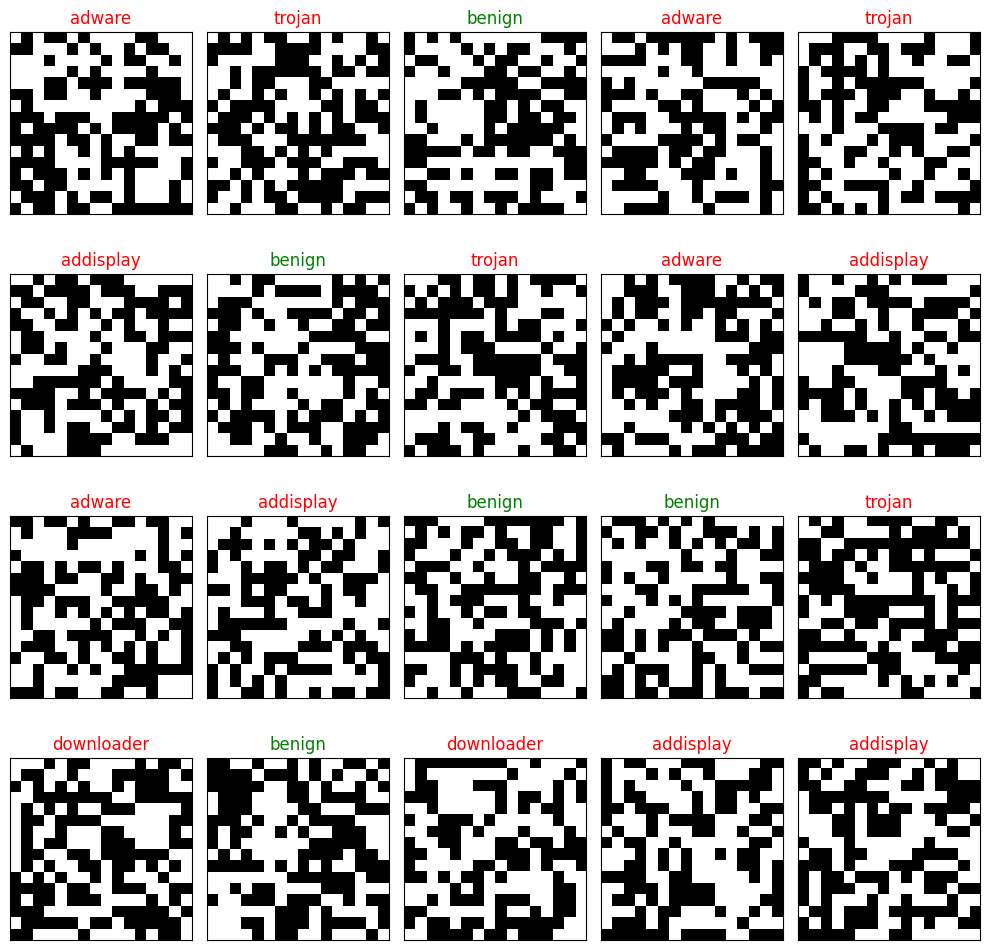

In [11]:
# With all of this in place let's visualize a few samples
# You can adjust the size here
tmp_indicies = np.random.randint(low=0, high=len(X), size=(20))

plt.figure(figsize=(10, 10))
for idx, value in enumerate(tmp_indicies):
    # Adjust the 4,5 here, if you changed the size above
    # Ensure it is a multiple of size
    ax = plt.subplot(4,5,idx+1)
    ax.set_title(label=malware_labels[y[value.item() ].item()  ], color='green' if malware_labels[y[value.item() ].item()  ] == 'benign' else 'red'    )
    ax.imshow(X=X[value].reshape(16, -1).cpu(), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

### Step 3:  
Load the classifier and put it in eval mode  

In [12]:
# Let's load the model we will target
# Now that we know this works. Time to move on.
loaded_pgd_model = torch.jit.load(f=r'../data/mal_net_tiny_malware_clf.jit', map_location=device)
loaded_pgd_model.eval()


RecursiveScriptModule(
  original_name=MalClassifier
  (conv_layers): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=BatchNorm2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Conv2d)
    (7): RecursiveScriptModule(original_name=BatchNorm2d)
    (8): RecursiveScriptModule(original_name=ReLU)
  )
  (global_avg_pool): RecursiveScriptModule(original_name=AdaptiveAvgPool2d)
  (classifier): RecursiveScriptModule(original_name=Conv2d)
)

### Step 4:   
Setup the PGD attack using Foolbox     

In [13]:
# Setup the foolbox model
fb_model = fb.PyTorchModel(model=loaded_pgd_model, bounds=(0, 1), device=device)

fb_model

In [14]:
# Setup our EPS bound
eps = 0.03

# Setup the attack
fb_attack = LinfPGD(steps=20, rel_stepsize=0.05, random_start=False)
fb_attack

LinfProjectedGradientDescentAttack(rel_stepsize=0.05, abs_stepsize=None, steps=20, random_start=False)

In [15]:
# Execute the attack   
raw_adversarial_example, clipped_adversarial_examples, success = fb_attack(model=fb_model, inputs=X, criterion=y, epsilons=eps)

In [16]:
# View one of the clipped adversarial examples
raw_adversarial_example[0]

tensor([[[0.0000, 0.9850, 1.0000, 0.0000, 0.9910, 0.9700, 0.0300, 0.0000,
          1.0000, 0.0000, 0.9700, 0.0000, 0.9700, 0.0300, 1.0000, 0.0300],
         [0.0300, 0.0300, 0.9700, 0.0300, 0.0000, 0.9910, 0.9700, 1.0000,
          0.9700, 1.0000, 0.0300, 0.0300, 0.9700, 0.0300, 0.0300, 0.0000],
         [0.9700, 0.0300, 0.9985, 0.9700, 1.0000, 0.9700, 0.0000, 0.9700,
          1.0000, 1.0000, 0.0300, 0.9790, 0.9970, 0.0300, 1.0000, 0.0000],
         [0.0000, 1.0000, 0.9790, 0.0000, 0.0000, 0.9820, 0.9760, 0.9700,
          0.9970, 0.0000, 0.9700, 0.9700, 0.0000, 1.0000, 0.0150, 0.0105],
         [0.0000, 0.9700, 0.9700, 1.0000, 1.0000, 0.9865, 0.9700, 1.0000,
          0.0300, 0.0000, 0.9700, 1.0000, 0.0000, 0.9835, 1.0000, 0.9700],
         [0.9985, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.9700,
          0.0300, 0.9700, 0.9715, 0.9700, 0.0300, 0.0300, 0.9700, 0.9700],
         [0.0300, 0.0300, 0.0000, 0.0300, 0.0300, 0.0300, 0.0300, 0.9730,
          1.0000, 0.0300, 0.0000

In [17]:
# View one of the clipped adversarial examples
clipped_adversarial_examples[0]

tensor([[[0.0000, 0.9850, 1.0000, 0.0000, 0.9910, 0.9700, 0.0300, 0.0000,
          1.0000, 0.0000, 0.9700, 0.0000, 0.9700, 0.0300, 1.0000, 0.0300],
         [0.0300, 0.0300, 0.9700, 0.0300, 0.0000, 0.9910, 0.9700, 1.0000,
          0.9700, 1.0000, 0.0300, 0.0300, 0.9700, 0.0300, 0.0300, 0.0000],
         [0.9700, 0.0300, 0.9985, 0.9700, 1.0000, 0.9700, 0.0000, 0.9700,
          1.0000, 1.0000, 0.0300, 0.9790, 0.9970, 0.0300, 1.0000, 0.0000],
         [0.0000, 1.0000, 0.9790, 0.0000, 0.0000, 0.9820, 0.9760, 0.9700,
          0.9970, 0.0000, 0.9700, 0.9700, 0.0000, 1.0000, 0.0150, 0.0105],
         [0.0000, 0.9700, 0.9700, 1.0000, 1.0000, 0.9865, 0.9700, 1.0000,
          0.0300, 0.0000, 0.9700, 1.0000, 0.0000, 0.9835, 1.0000, 0.9700],
         [0.9985, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.9700,
          0.0300, 0.9700, 0.9715, 0.9700, 0.0300, 0.0300, 0.9700, 0.9700],
         [0.0300, 0.0300, 0.0000, 0.0300, 0.0300, 0.0300, 0.0300, 0.9730,
          1.0000, 0.0300, 0.0000

In [18]:
# Get the Attack Success Rate
success.sum() / len(success)

tensor(0.7410)

### Step 5:  
Visualize the attack   

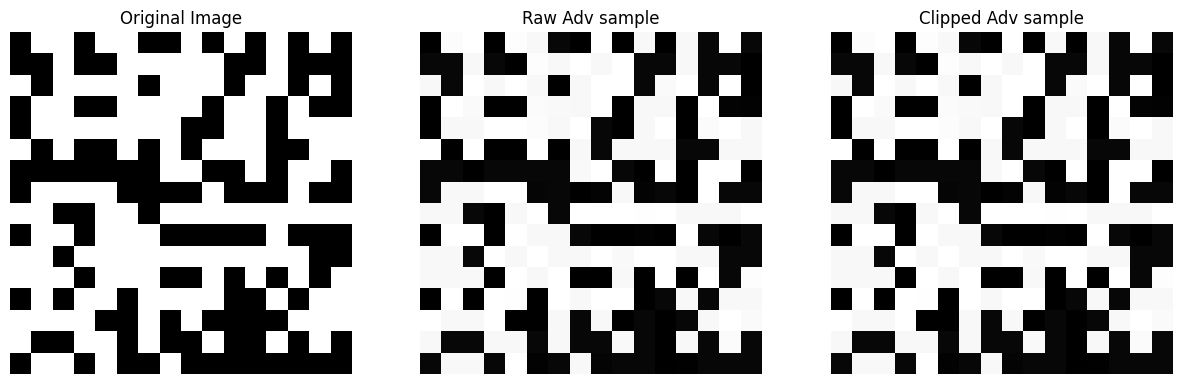

In [19]:
# We can now go ahead and plot the original image and the adversarial example
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,3,1)

# Detach is called because we calculated gradients
# By detaching we are no removing the need to backpropagate
ax.imshow(X[0].detach().squeeze(dim=0).squeeze(dim=0), cmap='gray')
ax.set_axis_off()
ax.set_title(label='Original Image')

# The perturbations are the gradients
ax = fig.add_subplot(1,3,2)
ax.imshow(raw_adversarial_example[0].detach().squeeze(dim=0).squeeze(dim=0), cmap='gray')
ax.set_axis_off()
ax.set_title(label='Raw Adv sample')

ax = fig.add_subplot(1,3,3)
# Detach is called because we calculated gradients
# By detaching we are no removing the need to backpropagate
ax.imshow(clipped_adversarial_examples[0].detach().numpy().squeeze(), cmap='gray')
ax.set_axis_off()
ax.set_title(label='Clipped Adv sample');

### Lab Takeaways:  
- We created a Projected Gradient Descent attack by leveraging Foolbox 